# FIFA Player Performance – Machine Learning Project

This project trains and exports a machine learning model using the FIFA Player Performance dataset from Kaggle.

The workflow includes:

1. Data loading
2. Exploratory Data Analysis (EDA)
3. Preprocessing pipeline definition
4. Model training
5. Model evaluation
6. Model export for inference use

The exported model will later be loaded in a separate inference application.

In [12]:
!pip -q install kagglehub scikit-learn pandas matplotlib joblib

In [13]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import joblib

RANDOM_STATE = 42

In [14]:
dataset_path = kagglehub.dataset_download("thedrzee/fifa-player-performance-dataset")
csv_files = glob.glob(os.path.join(dataset_path, "**", "*.csv"), recursive=True)
data_path = csv_files[0]
df = pd.read_csv(data_path)
df.head()

Using Colab cache for faster access to the 'fifa-player-performance-dataset' dataset.


,player_id,player_name,age,nationality,club,position,overall_rating,potential_rating,matches_played,goals,assists,minutes_played,market_value_million_eur,contract_years_left,injury_prone,transfer_risk_level
0,1,Player_1,23,Germany,Liverpool,ST,65,87,8,6,14,2976,122.51,3,No,Low
1,2,Player_2,36,England,FC Barcelona,ST,90,76,19,3,18,2609,88.47,5,No,High
2,3,Player_3,31,France,Juventus,RB,75,91,34,12,15,1158,20.24,3,No,Medium
3,4,Player_4,27,Portugal,Manchester City,LW,90,86,35,18,13,145,164.29,0,Yes,Medium
4,5,Player_5,24,Brazil,Liverpool,CDM,84,96,41,6,6,2226,121.34,4,No,Low


Dataset structure

Missing values

Numerical distributions

Feature types

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   player_id                 2800 non-null   int64  
 1   player_name               2800 non-null   object 
 2   age                       2800 non-null   int64  
 3   nationality               2800 non-null   object 
 4   club                      2800 non-null   object 
 5   position                  2800 non-null   object 
 6   overall_rating            2800 non-null   int64  
 7   potential_rating          2800 non-null   int64  
 8   matches_played            2800 non-null   int64  
 9   goals                     2800 non-null   int64  
 10  assists                   2800 non-null   int64  
 11  minutes_played            2800 non-null   int64  
 12  market_value_million_eur  2800 non-null   float64
 13  contract_years_left       2800 non-null   int64  
 14  injury_p

In [16]:
df.describe(include="all").T.head(20)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
player_id,2800.0,NaN,NaN,NaN,1400.5,808.434702,1.0,700.75,1400.5,2100.25,2800.0
player_name,2800,2800,Player_2784,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,2800.0,NaN,NaN,NaN,27.9525,6.750192,17.0,22.0,28.0,34.0,39.0
nationality,2800,8,Brazil,380,NaN,NaN,NaN,NaN,NaN,NaN,NaN
club,2800,7,Juventus,439,NaN,NaN,NaN,NaN,NaN,NaN,NaN
position,2800,9,ST,329,NaN,NaN,NaN,NaN,NaN,NaN,NaN
overall_rating,2800.0,NaN,NaN,NaN,76.866786,9.921113,60.0,68.0,77.0,85.0,94.0
potential_rating,2800.0,NaN,NaN,NaN,81.563929,9.755799,65.0,73.0,82.0,90.0,98.0
matches_played,2800.0,NaN,NaN,NaN,27.135714,15.979627,0.0,13.75,27.0,41.0,54.0
goals,2800.0,NaN,NaN,NaN,19.261786,11.567858,0.0,9.0,19.0,30.0,39.0


In [17]:
missing = df.isna().mean().sort_values(ascending=False)
missing.head(20)

,0
player_id,0.0
player_name,0.0
age,0.0
nationality,0.0
club,0.0
position,0.0
overall_rating,0.0
potential_rating,0.0
matches_played,0.0
goals,0.0


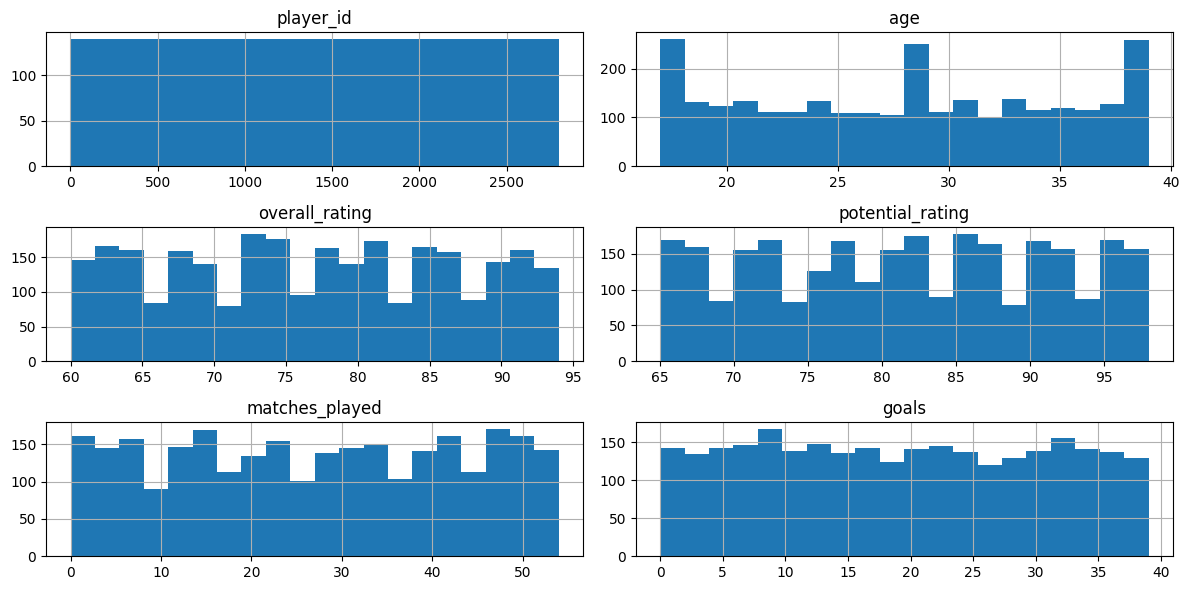

In [18]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
sample_num = num_cols[:6] if len(num_cols) >= 6 else num_cols

if len(sample_num) > 0:
    df[sample_num].hist(figsize=(12,6), bins=20)
    plt.tight_layout()
    plt.show()

Target Selection

The system automatically selects a numerical target column.
If a common FIFA rating column exists, it will use that.
Otherwise, it selects the last numerical column.

In [19]:
candidate_targets = ["overall", "Overall", "rating", "Rating", "performance", "Performance", "value", "Value"]

target_col = None
for c in candidate_targets:
    if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
        target_col = c
        break

if target_col is None:
    target_col = num_cols[-1]

df_model = df.dropna(subset=[target_col]).copy()
target_col

'contract_years_left'

## 5. Define Problem Type

The project automatically detects whether this is:
- A classification problem
- A regression problem

In [20]:
y = df_model[target_col]
unique_vals = y.nunique(dropna=True)
is_binary = unique_vals == 2
looks_classification = (unique_vals <= 15) and (pd.api.types.is_integer_dtype(y) or is_binary)
problem_type = "classification" if looks_classification else "regression"
problem_type

'classification'

In [21]:
X = df_model.drop(columns=[target_col])
y = df_model[target_col]

num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = [c for c in X.columns if c not in num_features]

stratify = y if problem_type == "classification" else None

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=stratify
)

X_train.shape, X_test.shape

((2240, 15), (560, 15))

## 7. Preprocessing Pipeline

Numerical features:
- Median imputation
- Standard scaling

Categorical features:
- Most frequent imputation
- One-hot encoding

In [22]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])

In [23]:
if problem_type == "classification":
    model = RandomForestClassifier(
        n_estimators=300,
        random_state=RANDOM_STATE,
        class_weight="balanced"
    )
else:
    model = RandomForestRegressor(
        n_estimators=400,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

clf = Pipeline([
    ("preprocess", preprocess),
    ("model", model)
])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['player_id', 'age',
                                                   'overall_rating',
                                                   'potential_rating',
                                                   'matches_played', 'goals',
                                                   'assists', 'minutes_played',
                                                   'market_value_million_eur']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['player_name', 'nationality',
                                                   'club', 'position',
                                                   'injury_prone',
                                                   'transfer_risk_level'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, random_state=42))])

In [24]:
y_pred = clf.predict(X_test)

if problem_type == "classification":
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    print("Accuracy:", acc)
    print("F1:", f1)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
else:
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("R2:", r2)

Accuracy: 0.17142857142857143
F1: 0.16541323884940906
              precision    recall  f1-score   support

           0       0.15      0.10      0.12        89
           1       0.14      0.13      0.13        92
           2       0.14      0.16      0.15        98
           3       0.19      0.11      0.14        89
           4       0.23      0.33      0.27        99
           5       0.17      0.17      0.17        93

    accuracy                           0.17       560
   macro avg       0.17      0.17      0.16       560
weighted avg       0.17      0.17      0.17       560

[[ 9 11 20  5 24 20]
 [13 12 25 12 16 14]
 [10 18 16 10 26 18]
 [14 11 20 10 20 14]
 [10 14 19 10 33 13]
 [ 5 22 18  7 25 16]]


In [25]:
os.makedirs("exported_model", exist_ok=True)

joblib.dump(clf, "exported_model/fifa_pipeline_model.joblib")

metadata = {
    "target_col": target_col,
    "problem_type": problem_type,
    "data_csv_used": os.path.basename(data_path),
    "random_state": RANDOM_STATE
}

with open("exported_model/metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

"Model exported successfully."

'Model exported successfully.'